# Linear Model

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from statsmodels.stats.diagnostic import het_white
import scipy.stats
import random
#matplotlib.style.use('ggplot')

/home/lucia/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Reading and Formatting Data

In [2]:
md_actor_producer = pd.read_csv("./data/md_actor_producer.csv")

# movie_era == 1.0 if year >= 1999, movie_era == 0 if year < 1999
md_actor_producer['movie_era'] = (md_actor_producer['year']>=1999)*1.0

# Joining P and PG ratings
bool_list = (md_actor_producer['rating'] == 'G') | (md_actor_producer['rating'] == 'PG')
pgs = pd.Series(['PG']*len(md_actor_producer))
md_actor_producer['ratingPGG'] = pgs*bool_list + md_actor_producer['rating']*~bool_list

# Joining P, PG, PG-13 ratings
bool_list = (md_actor_producer['rating'] == 'G') | (md_actor_producer['rating'] == 'PG') | \
            (md_actor_producer['rating'] == 'PG-13')
pgs = pd.Series(['PG']*len(md_actor_producer))
md_actor_producer['ratingPG'] = pgs*bool_list + md_actor_producer['rating']*~bool_list

# Grouping genres to categories
def get_genre(s):
    if 'Comedy' in s:
        return 'Comedy+Romance'
    elif 'Action' in s:
        return 'Action+Horror'
    elif 'Drama' in s:
        return 'Drama'
    elif 'Horror' in s:
        return 'Action+Horror'
    elif 'Romance' in s:
        return 'Comedy+Romance'
    elif 'Sci-Fi':
        return 'Sci-Fi'
    else:
        return 'Uncategorized'

def get_genre2(s):
    if 'Comedy' in s:
        return 'Comedy+Romance+Drama'
    elif 'Action' in s:
        return 'Action+Horror+Sci-Fi'
    elif 'Drama' in s:
        return 'Comedy+Romance+Drama'
    elif 'Sci-Fi':
        return 'Action+Horror+Sci-Fi'
    else:
        return 'Uncategorized'
    
md_actor_producer['genre_adj'] = md_actor_producer['genre'].map(lambda s: get_genre(s))
md_actor_producer['genre2'] = md_actor_producer['genre_adj'].map(lambda s: get_genre2(s))

# adjusting for exp effect in theaters
md_actor_producer['theatersdiv1000'] = md_actor_producer.theaters/1000.0
md_actor_producer['theatersdiv1000exp'] = np.exp(md_actor_producer.theatersdiv1000)
# Printing range of theaters/1000 and exp(theaters/1000)
print max(md_actor_producer.theatersdiv1000)
print max(md_actor_producer.theatersdiv1000exp)
print min(md_actor_producer.theatersdiv1000)
print min(md_actor_producer.theatersdiv1000exp)

4.468
87.1821841644
0.005
1.00501252086


# Running Linear Regression Model

In [3]:
# Split the data into training and testing sets
random.seed(123)
train, test = train_test_split(md_actor_producer[ md_actor_producer['movie_era'] == 1], test_size = 0.2)
print len(train)
print len(test)
print train.groupby('ratingPG').agg(['count'])['movie_title']
print train.groupby('genre2').agg(['count'])['movie_title']

1036
259
          count
ratingPG       
PG          632
R           404
                      count
genre2                     
Action+Horror+Sci-Fi    485
Comedy+Romance+Drama    551


In [4]:
# Show outliers for training data
outliers = train.sort_values(by=['total_gross','budget'], ascending=False)
outliers[['movie_title','total_gross','budget','release_date_x','movie_score']].head(12)

,movie_title,total_gross,budget,release_date_x,movie_score
563,Jurassic World,6.522706e+08,150000000.0,2015-06-12,59
934,Star Wars: Episode I - The Phantom Menace,6.164563e+08,164450000.0,1999-05-19,51
889,Shrek 2,5.559451e+08,189000000.0,2004-05-19,75
924,Spider-Man,5.328924e+08,183480000.0,2002-05-03,73
1136,The Lord of the Rings: The Return of the King,4.863652e+08,121260000.0,2003-12-17,94
925,Spider-Man 2,4.707181e+08,252000000.0,2004-06-30,83
1040,The Dark Knight Rises,4.660647e+08,260000000.0,2012-07-20,78
1289,Toy Story 3,4.523553e+08,218000000.0,2010-06-18,92
1137,The Lord of the Rings: The Two Towers,4.485226e+08,124080000.0,2002-12-18,88
1296,Transformers: Revenge of the Fallen,4.463442e+08,222000000.0,2009-06-24,35


In [5]:
def get_summary_noint(s, train, validation, k, drop_list=[]):
    y_train, X_train = dmatrices(s, data=train, return_type='dataframe')
    y_valid, X_valid = dmatrices(s, data=validation, return_type='dataframe')
    X_train = X_train.drop('Intercept',1)
    X_valid = X_valid.drop('Intercept',1)
    for item in drop_list:
        X_train = X_train.drop(item,1)
        X_valid = X_valid.drop(item,1)
    model = sm.OLS(y_train, X_train).fit()
    print model.summary()
    predictions = model.predict(X_valid)
    y_valid = np.array(y_valid.total_gross)
    rsq_noint = 1.0 - (np.mean((y_valid - predictions)**2))/(np.mean(y_valid**2))
    #http://stats.stackexchange.com/questions/26176/
    #removal-of-statistically-significant-intercept-term-increases-r2-in-linear-mo
    m = len(y_valid)*1.0 # number of points
    dfe = m - k
    dft = m 
    adj_rsq = 1 - ((np.mean((y_valid - predictions)**2))/dfe)/((np.mean(y_valid**2))/dft)
    print "R squared - no intercept: ", rsq_noint
    print "Adjusted R squared - no intercept: ", adj_rsq
    return (model,predictions,y_valid)
     
def get_summary(s, train, validation, k, drop_list =[]):
    y_train, X_train = dmatrices(s, data=train, return_type='dataframe')
    y_valid, X_valid = dmatrices(s, data=validation, return_type='dataframe')
    for item in drop_list:
        X_train = X_train.drop(item,1)
        X_valid = X_valid.drop(item,1)
    model = sm.OLS(y_train, X_train).fit()
    print model.summary()
    predictions = model.predict(X_valid)
    y_valid = np.array(y_valid.total_gross)
    average = np.mean(y_valid)
    sse = np.sum((predictions - y_valid)**2.0)
    tss = np.sum((average - y_valid)**2.0)
    rsq = 1.0 - sse/tss
    m = len(y_valid)*1.0 # number of points
    dfe = m - k - 1
    dft = m - 1
    adj_rsq = 1 - (sse/dfe)/(tss/dft)
    print "R squared: ", rsq
    print "Adjusted R squared: ", adj_rsq
    return (model,predictions,y_valid)

In [6]:
(model,predictions,y_test) = get_summary_noint('total_gross ~ producer_score + actors_score + budget*ratingPG + budget*genre2', 
                  train, test, 5.0, ['ratingPG[T.R]','genre2[T.Comedy+Romance+Drama]'])

                            OLS Regression Results                            
Dep. Variable:            total_gross   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     539.7
Date:                Fri, 22 Apr 2016   Prob (F-statistic):          7.93e-285
Time:                        23:34:03   Log-Likelihood:                -20125.
No. Observations:                1036   AIC:                         4.026e+04
Df Residuals:                    1031   BIC:                         4.028e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------

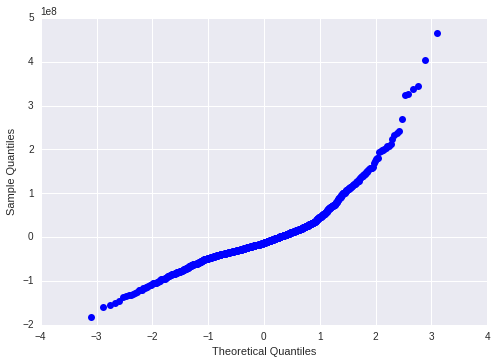

/home/lucia/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


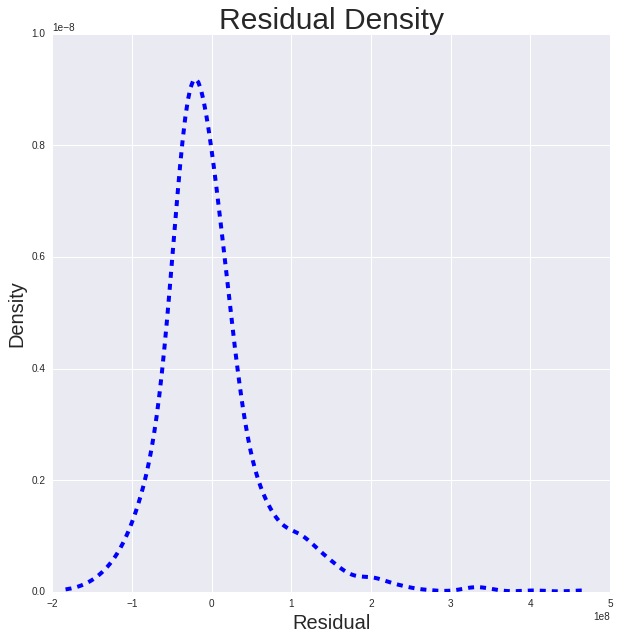

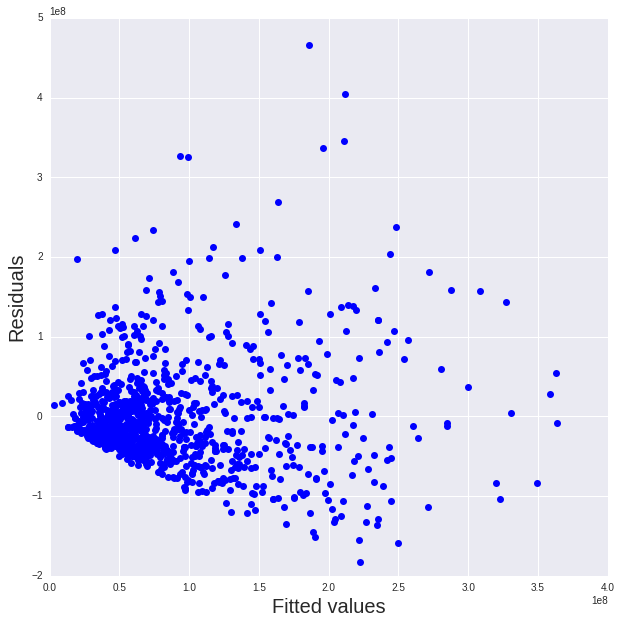

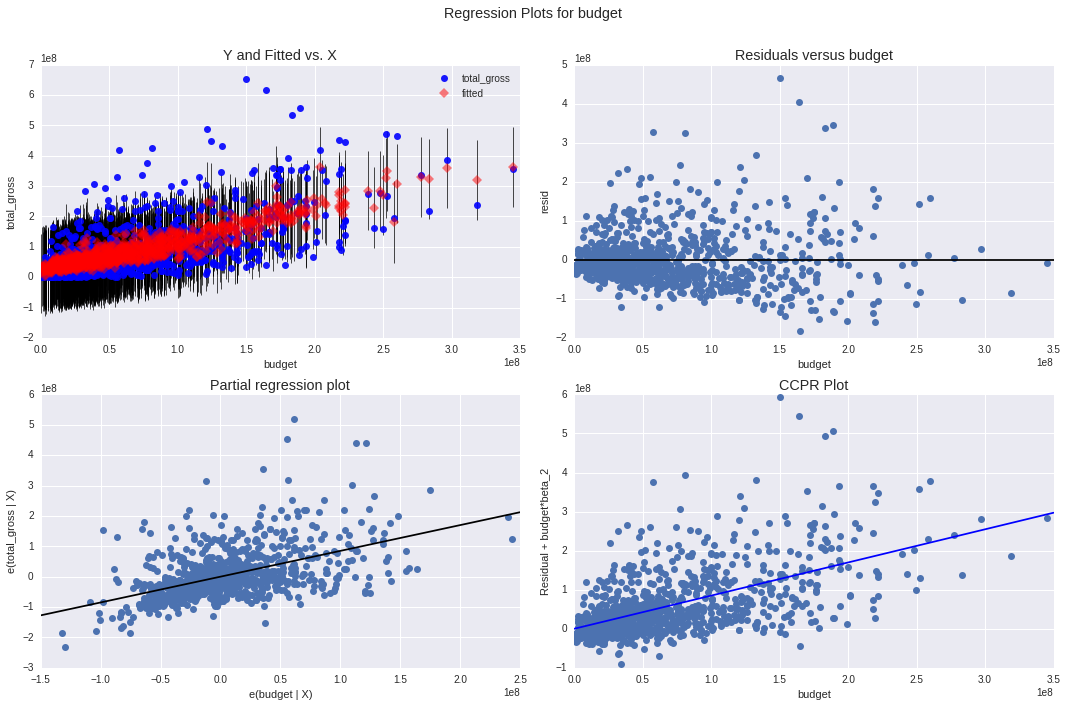

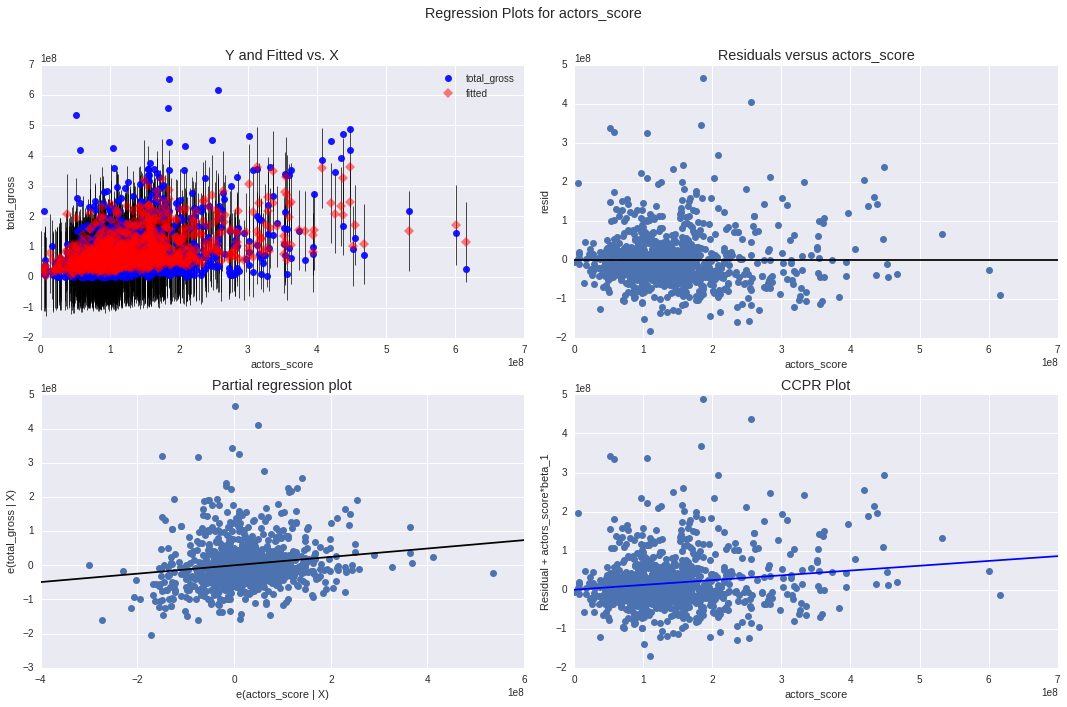

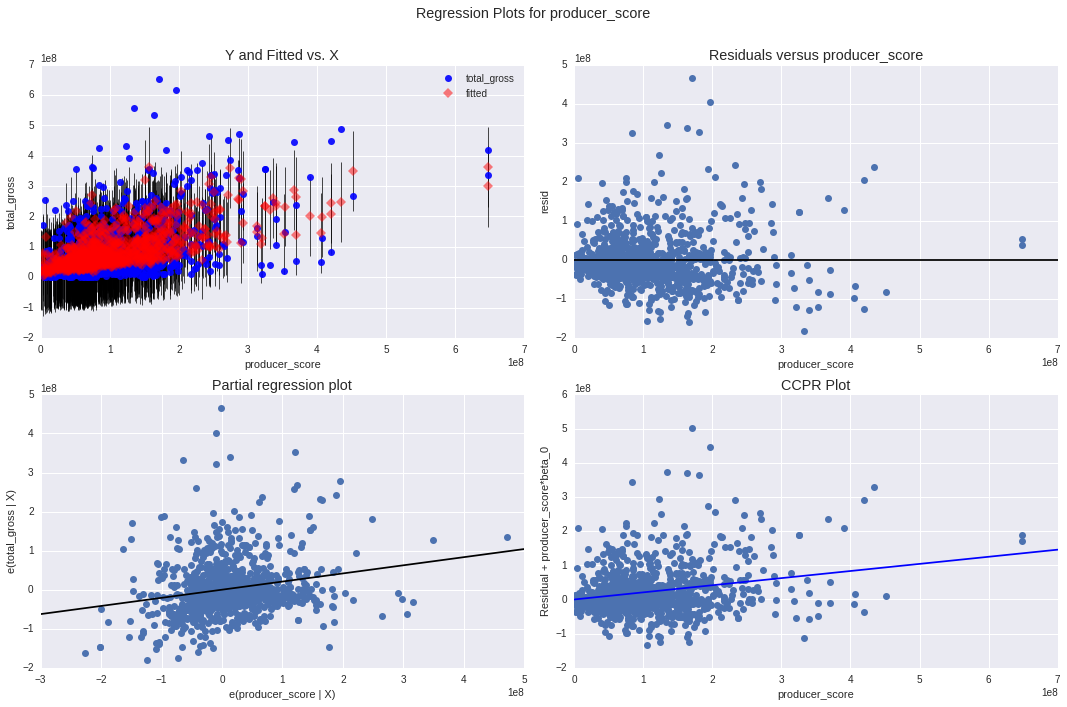

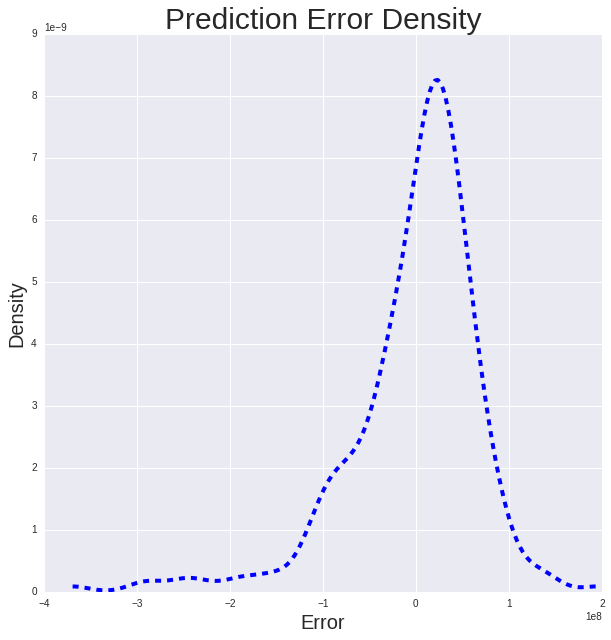

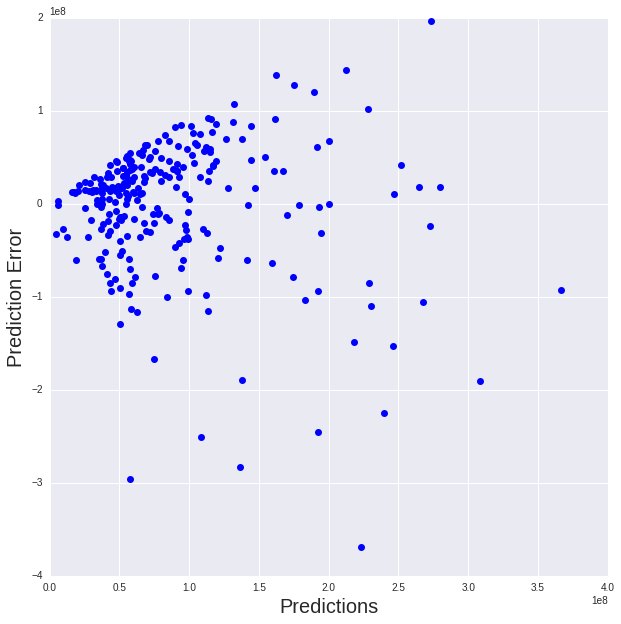

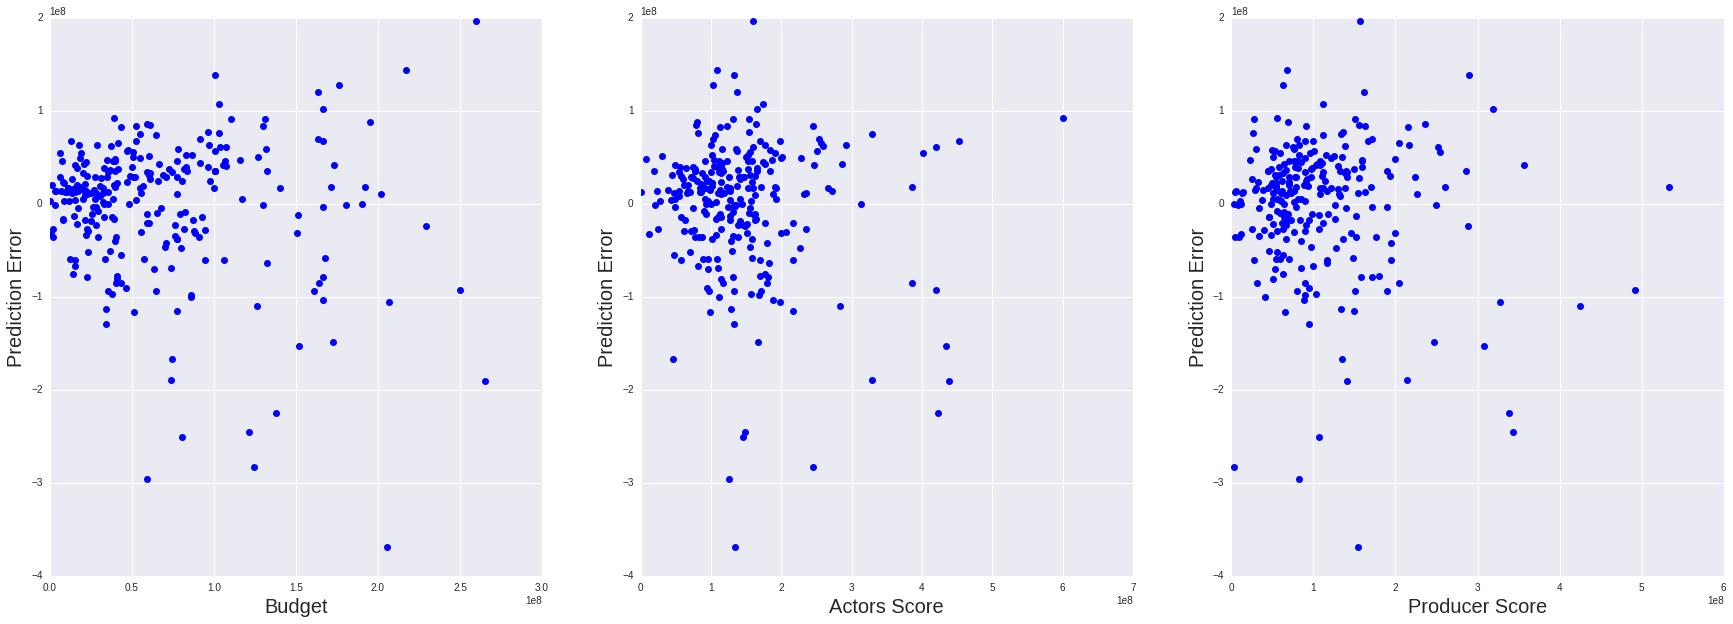

In [7]:
# Q-Q plot of residuals
res = model.resid
fig = sm.qqplot(res)
plt.savefig('./figs/resQQplot.png')
plt.show()

# Plot Residual Error Density
#compute the density for the residuals data
density_res = scipy.stats.gaussian_kde(res)    #use the scipy density calculator
density_res.covariance_factor = lambda : .25    #set the covariance factor so that plots analogous to R's are plotted
density_res._compute_covariance()    #recompute using the new covariance factor
xsres = np.linspace(min(res),max(res),200)    #set the x range
plt.close('all')       
plt.figure(figsize = (10,10))  
plt.plot(xsres,density_res(xsres),'b--',lw=4) 
plt.xlabel('Residual',fontsize=20)    
plt.ylabel('Density',fontsize=20) 
plt.title("Residual Density",fontsize=30)
plt.legend(loc="best")
plt.grid(True)
plt.savefig('./figs/res_density.png')
plt.show()

fitted = model.fittedvalues

# Plot res vs fitted
plt.close('all')       
plt.figure(figsize = (10,10))  
myplot = plt.plot(fitted,res,'bo',lw=4) 
plt.xlabel('Fitted values',fontsize=20)    
plt.ylabel('Residuals',fontsize=20) 
plt.legend(loc="best")
plt.grid(True)
plt.savefig('./figs/res_vs_fitted.png')
plt.show()

# Residuals vs X
plt.close('all')
fig = plt.figure(figsize=(15,10))
fig = sm.graphics.plot_regress_exog(model, "budget", fig=fig)
plt.savefig('./figs/resplot_budget.png')
plt.show()

plt.close('all')
fig = plt.figure(figsize=(15,10))
fig = sm.graphics.plot_regress_exog(model, "actors_score", fig=fig)
plt.savefig('./figs/resplot_actors_score.png')
plt.show()

plt.close('all')
fig = plt.figure(figsize=(15,10))
fig = sm.graphics.plot_regress_exog(model, "producer_score", fig=fig)
plt.savefig('./figs/resplot_producer_score.png')
plt.show()


# Get distribution of prediction errors
#predictions = model.predict(X_test)
pred_errors = predictions - y_test

# Plot Prediction Error Density
#compute the density for the errors data
density_errors = scipy.stats.gaussian_kde(pred_errors)    #use the scipy density calculator
density_errors.covariance_factor = lambda : .25    #set the covariance factor so that plots analogous to R's are plotted
density_errors._compute_covariance()    #recompute using the new covariance factor
xs = np.linspace(min(pred_errors),max(pred_errors),200)    #set the x range
plt.close('all')       
plt.figure(figsize = (10,10))  
plt.plot(xs,density_errors(xs),'b--',lw=4) 
plt.xlabel('Error',fontsize=20)    
plt.ylabel('Density',fontsize=20) 
plt.title("Prediction Error Density",fontsize=30)
plt.legend(loc="best")
plt.grid(True)
plt.savefig('./figs/preder_density.png')
plt.show()

# Plot errors vs predictions
plt.close('all')       
plt.figure(figsize = (10,10))  
plt.plot(predictions,pred_errors,'bo',lw=4) 
plt.xlabel('Predictions',fontsize=20)    
plt.ylabel('Prediction Error',fontsize=20) 
plt.legend(loc="best")
plt.grid(True)
plt.savefig('./figs/preder_vs_predictions.png')
plt.show()

# Plot errors vs X
plt.figure(figsize = (30,10))   
plt.subplot(1,3,1)
plt.plot(test.budget,pred_errors,'bo', lw=4)    
plt.xlabel('Budget',fontsize=20)    
plt.ylabel('Prediction Error',fontsize=20) 
plt.subplot(1,3,2)
plt.plot(test.actors_score,pred_errors,'bo', lw=4)    
plt.xlabel('Actors Score',fontsize=20)    
plt.ylabel('Prediction Error',fontsize=20)
plt.subplot(1,3,3)
plt.plot(test.producer_score,pred_errors,'bo', lw=4)    
plt.xlabel('Producer Score',fontsize=20)    
plt.ylabel('Prediction Error',fontsize=20)
plt.savefig('./figs/preder_vs_X.png')
plt.show()

In [8]:
# Check for heteroskedasticity
# Rsq == 0, that is, negligible heteroskedasticity
train['errors'] = res
y, X = dmatrices('errors ~ producer_score + actors_score + budget*ratingPG + budget*genre2',
                 data=train, return_type='dataframe')
X = X.drop('Intercept',1)
X = X.drop('ratingPG[T.R]',1)
X = X.drop('genre2[T.Comedy+Romance+Drama]',1)
res_results = sm.OLS(y, X).fit()
print res_results.summary()

print het_white(res,X)

# Rsq == 0, that is, negligible heteroskedasticity
test['errors'] = pred_errors
y, X = dmatrices('errors ~ producer_score + actors_score + budget*ratingPG + budget*genre2',
                 data=test, return_type='dataframe')
X = X.drop('Intercept',1)
X = X.drop('ratingPG[T.R]',1)
X = X.drop('genre2[T.Comedy+Romance+Drama]',1)
res_results = sm.OLS(y, X).fit()
print res_results.summary()

                            OLS Regression Results                            
Dep. Variable:                 errors   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                     0.000
Date:                Fri, 22 Apr 2016   Prob (F-statistic):               1.00
Time:                        23:34:10   Log-Likelihood:                -20125.
No. Observations:                1036   AIC:                         4.026e+04
Df Residuals:                    1031   BIC:                         4.028e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------

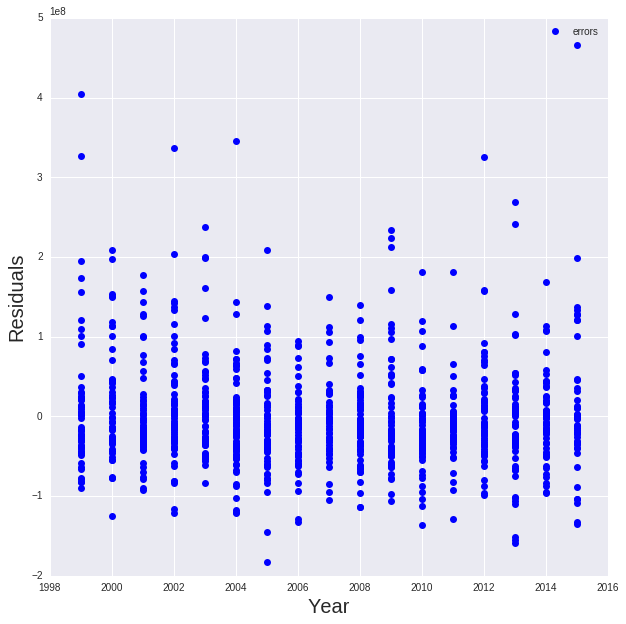

In [9]:
# Plot errors vs year
plt.close('all')       
plt.figure(figsize = (10,10))
plt.plot(train['year'],train['errors'],'bo',lw=4) 
plt.xlabel('Year',fontsize=20)    
plt.ylabel('Residuals', fontsize=20) 
plt.legend(loc="best")
plt.grid(True)

plt.savefig('./figs/res_vs_year.png')
plt.show()

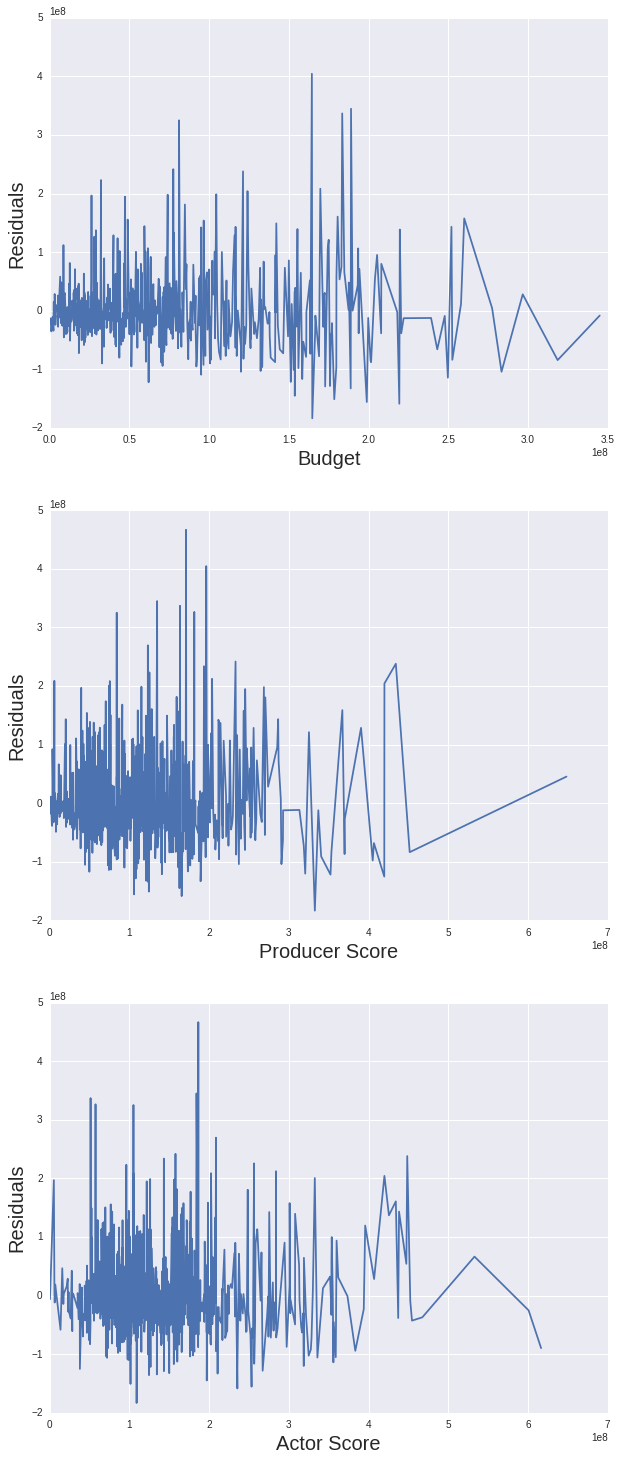

In [10]:
# Plot mean/median errors vs year, budget, etc.

by_year = train.groupby('year').mean().reset_index()[['year','errors']]
by_budget = train.groupby('budget').mean().reset_index()[['budget','errors']]
by_runtime = train.groupby('runtime').median().reset_index()[['runtime','errors']]
by_rating = train.groupby('rating').mean().reset_index()[['rating','errors']]
by_actor = train.groupby('actors_score').median().reset_index()[['actors_score','errors']]
by_producer = train.groupby('producer_score').median().reset_index()[['producer_score','errors']]
                                                                
plt.close('all')       
plt.figure(figsize = (10,25))
plt.subplot(3,1,1)
plt.plot(by_budget.budget, by_budget.errors)
plt.xlabel('Budget',fontsize=20)    
plt.ylabel('Residuals', fontsize=20) 
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(by_producer.producer_score, by_producer.errors)
plt.xlabel('Producer Score', fontsize=20)    
plt.ylabel('Residuals', fontsize=20) 
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(by_actor.actors_score, by_actor.errors)
plt.xlabel('Actor Score', fontsize=20)    
plt.ylabel('Residuals', fontsize=20) 
plt.grid(True)

plt.savefig('../figs/meanres_vs_X.png')
plt.show()


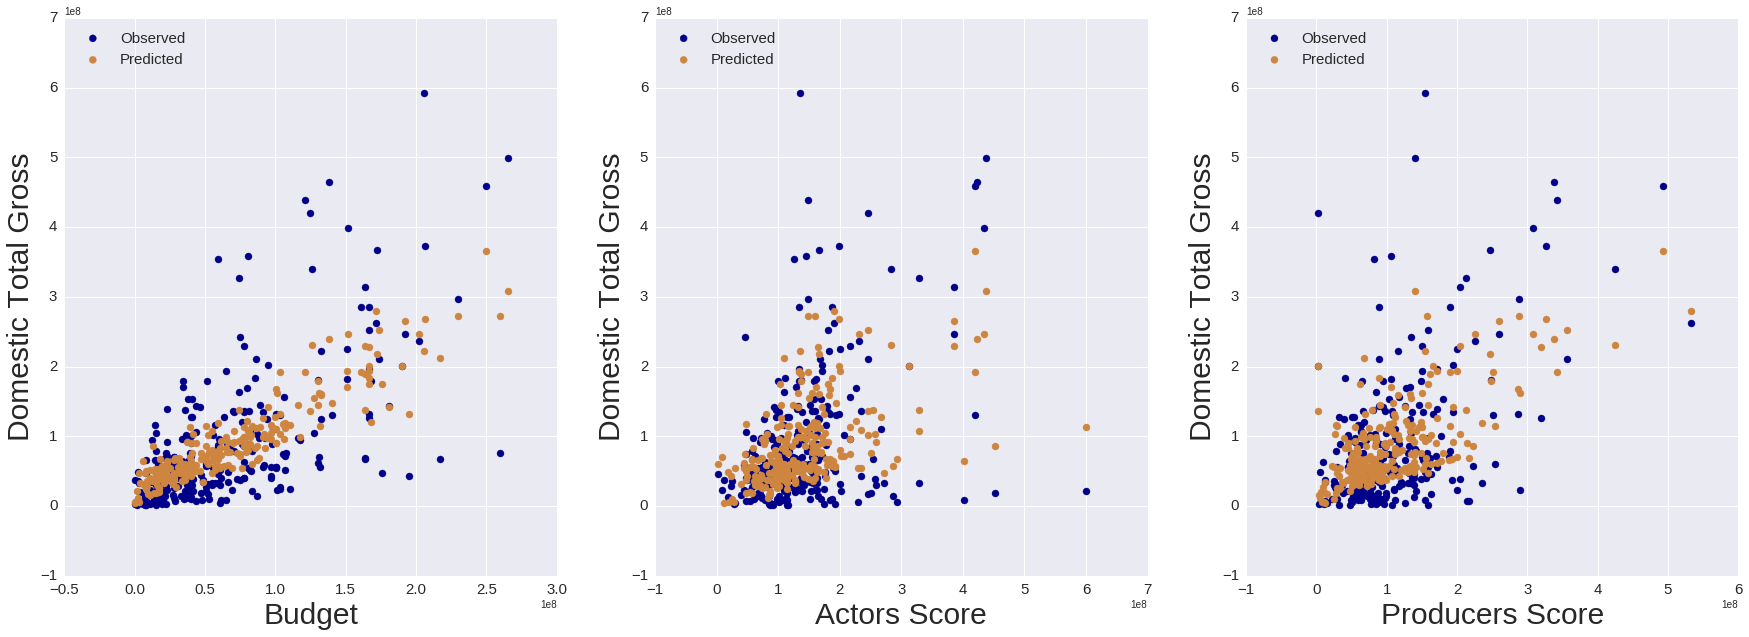

In [11]:
plt.close('all')
#'#63d297'
plt.figure(figsize = (30,10))
plt.subplot(1,3,1)
plt.scatter(test.budget, test.total_gross, color = '#00008B', label='Observed',s=50)
plt.scatter(test.budget, predictions, color = '#CD853F', label='Predicted',s=50)    
plt.xlabel('Budget',fontsize=30)    
plt.ylabel('Domestic Total Gross',fontsize=30) 
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc=2,fontsize=15)
plt.grid(True)
plt.subplot(1,3,2)
plt.scatter(test.actors_score, test.total_gross, color = '#00008B', label='Observed',s=50)
plt.scatter(test.actors_score, predictions, color = '#CD853F', label='Predicted',s=50)    
plt.xlabel('Actors Score',fontsize=30)    
plt.ylabel('Domestic Total Gross',fontsize=30) 
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc=2,fontsize=15)
plt.grid(True)
plt.subplot(1,3,3)
plt.scatter(test.producer_score, test.total_gross, color = '#00008B', label='Observed',s=50)
plt.scatter(test.producer_score, predictions, color = '#CD853F', label='Predicted',s=50)    
plt.xlabel('Producers Score',fontsize=30)    
plt.ylabel('Domestic Total Gross',fontsize=30) 
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc=2,fontsize=15)
plt.grid(True)
plt.savefig('../figs/gross_vs_X.png')